In [1]:
import os
import torch
import matplotlib.pyplot as plt
from datetime import datetime

from data.toy_data.hyperbolic import hyperbolic
from data.toy_data.circle import circle
from src.diffeomorphisms.vanilla_hyperboloid import Vanilla_into_Hyperboloid
from src.diffeomorphisms.vanilla_sphere import Vanilla_into_Sphere
from src.manifolds.pull_back_manifold import PullBackManifold
from src.riemannian_autoencoder import Curvature_Corrected_Riemannian_Autoencoder
from src.riemannian_autoencoder.low_rank_approximation.naive_tsvd import naive_low_rank_approximation

# set seed
torch.manual_seed(31)

In [2]:
# global parameters
num_data = 51

Hyperbolic data

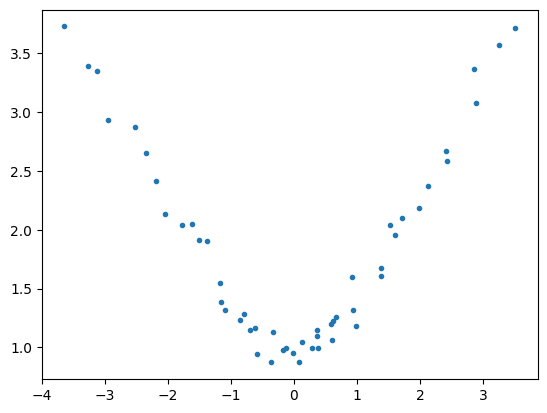

In [3]:
# Construct data
h_data = hyperbolic(num_data, noise=0.1)

plt.plot(h_data[:,0], h_data[:,1], '.')
plt.show()

In [4]:
# construct pull-back manifold
h_offset = torch.zeros((2,))
h_orthogonal = torch.eye(2,2)
h_diffeo = Vanilla_into_Hyperboloid(2, h_offset, h_orthogonal)

h_M = PullBackManifold(h_diffeo)

Evaluate geometry

In [5]:
# choose special points
h_z1 = h_data[0][None]
h_z2 = h_data[int(num_data/2)][None]
h_z3 = h_data[int(3 *num_data/4)][None]
h_z4 = torch.tensor([0., 1.])[None]

In [6]:
# compute geodesics
t = torch.linspace(0,1,100)
h_gamma_12_t =  h_M.geodesic(h_z1, h_z2, t)
h_gamma_13_t =  h_M.geodesic(h_z1, h_z3, t)

/Users/wdiepeveen/Documents/PhD/Projects/10 - Learning Riemannian Geometry/src/article/Pulling-back-symmetric-Riemannian-geometry-for-data-analysis/src/diffeomorphisms/simple_diffeomorphisms/stereographic_hyperboloid.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  output[-1] = torch.sqrt(s_sq.T + 1)


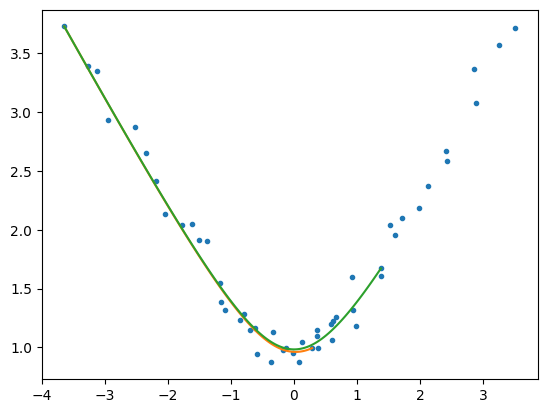

In [7]:
# plot geodesics
plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(h_gamma_12_t.squeeze().detach().numpy()[:,0], h_gamma_12_t.squeeze().detach().numpy()[:,1])
plt.plot(h_gamma_13_t.squeeze().detach().numpy()[:,0], h_gamma_13_t.squeeze().detach().numpy()[:,1])
plt.show()

In [8]:
# compute barycentre
h_barycentre = h_M.barycentre(h_data[None])

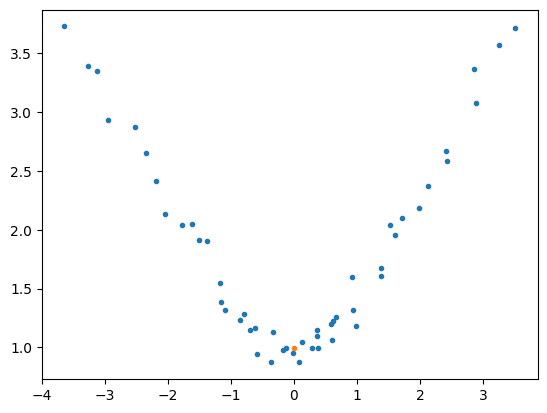

In [9]:
# plot barycentre
plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(h_barycentre[:,0].detach().numpy(), h_barycentre[:,1].detach().numpy(), '.')
plt.show()

In [10]:
# compute logs to all data
h_logs = h_M.log(h_barycentre, h_data[None])[0]

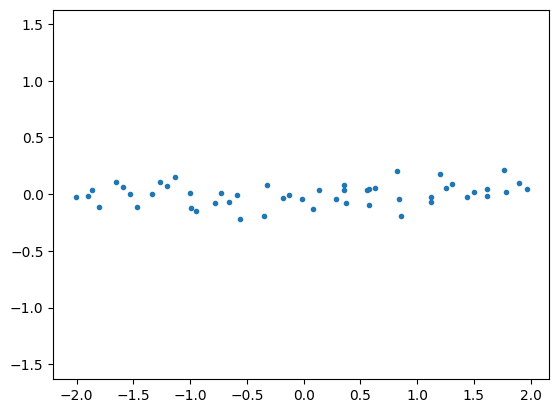

In [11]:
plt.plot(h_logs.squeeze().detach().numpy()[:,0], h_logs.squeeze().detach().numpy()[:,1], '.')
plt.axis('equal')
plt.show()

In [12]:
# rank 1 approximation
h_z = h_barycentre.squeeze()
h_R_z, h_U = naive_low_rank_approximation(h_M, h_z, h_data, 1)
h_w_z = h_R_z / h_M.norm(h_z[None], h_R_z[None])[:,None]
print(h_w_z)
print(h_U.shape)

tensor([[-0.9999, -0.0176]], grad_fn=<DivBackward0>)
torch.Size([1, 51])


In [13]:
# compute error
h_logs_approx = torch.einsum("kN,kd->Nd", h_U, h_R_z)

h_tangent_space_error = torch.sum(h_M.norm(h_z[None], h_logs_approx[None] - h_logs[None])**2)
print(h_tangent_space_error)

h_manifold_error = torch.sum(h_M.distance(h_data[:,None], h_M.exp(h_z[None], h_logs_approx[None])[0][:,None])**2)
print(h_manifold_error)

# TODO implement curvature corrected low rank approximation

tensor(0.2217, grad_fn=<SumBackward0>)
tensor(0.3352, grad_fn=<SumBackward0>)


In [14]:
h_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(h_M, h_z, h_w_z)

In [15]:
# project noisy data onto manifold with RAE
noisy_h_data = hyperbolic(500, noise=0.1) 
projected_h_mesh = h_rae_w_z.project_on_manifold(noisy_h_data)

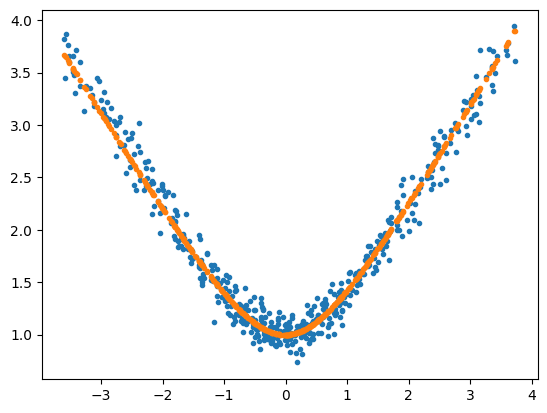

In [16]:
# plot results
plt.plot(noisy_h_data[:,0], noisy_h_data[:,1], '.')
plt.plot(projected_h_mesh.cpu().detach().numpy()[:,0], projected_h_mesh.cpu().detach().numpy()[:,1], '.')
plt.show()

Circular data

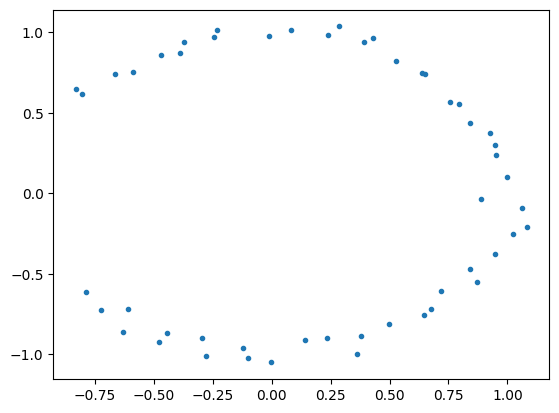

In [17]:
# Construct data
c_data = circle(num_data, noise=0.05)

plt.plot(c_data[:,0], c_data[:,1], '.')
plt.show()

In [18]:
# construct pull-back manifold
c_offset = torch.zeros((2,))
c_orthogonal = torch.eye(2,2)
c_diffeo = Vanilla_into_Sphere(2, c_offset, c_orthogonal)

c_M = PullBackManifold(c_diffeo)

Evaluate geometry

In [19]:
# choose special points
c_z1 = c_data[0][None]
c_z2 = c_data[int(4*num_data/7)][None]
c_z3 = c_data[int(num_data/2)][None]
c_z4 = torch.tensor([1., 0.])[None]

In [20]:
# compute geodesics
t = torch.linspace(0,1,100)
c_gamma_12_t =  c_M.geodesic(c_z1, c_z2, t)
c_gamma_13_t =  c_M.geodesic(c_z1, c_z3, t)

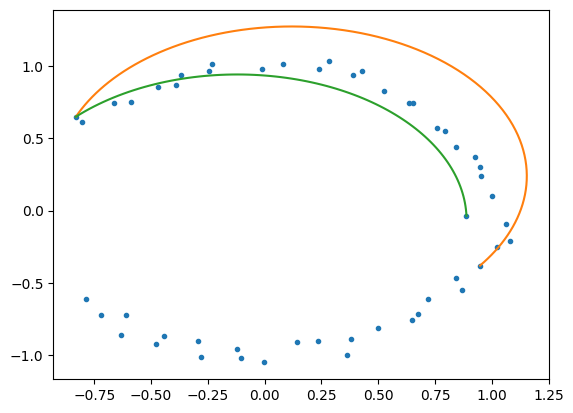

In [21]:
# plot geodesics
plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(c_gamma_12_t.squeeze().detach().numpy()[:,0], c_gamma_12_t.squeeze().detach().numpy()[:,1])
plt.plot(c_gamma_13_t.squeeze().detach().numpy()[:,0], c_gamma_13_t.squeeze().detach().numpy()[:,1])
plt.show()

In [22]:
# compute barycentre
c_barycentre = c_M.barycentre(c_data[None])

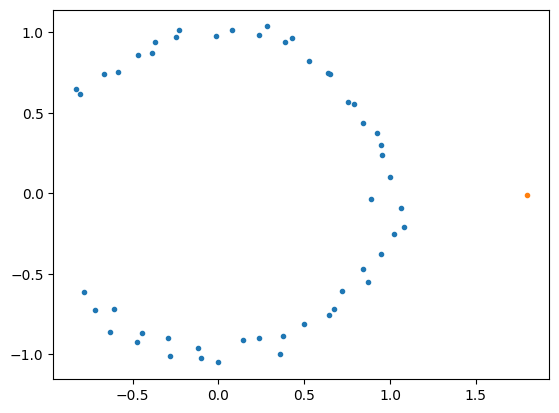

In [23]:
# plot barycentre
plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(c_barycentre[:,0].detach().numpy(), c_barycentre[:,1].detach().numpy(), '.')
plt.show()

In [24]:
# compute logs to all data
c_logs = c_M.log(c_z4, c_data[None])[0]

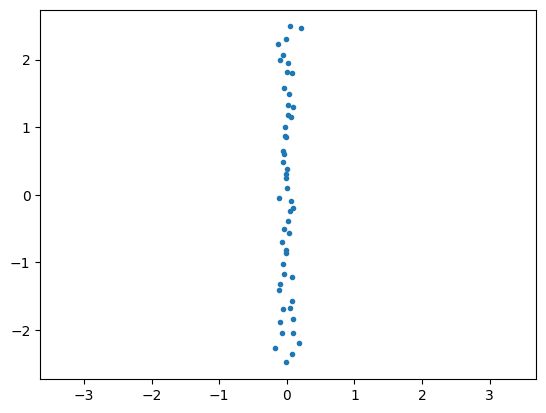

In [25]:
plt.plot(c_logs.squeeze().detach().numpy()[:,0], c_logs.squeeze().detach().numpy()[:,1], '.')
plt.axis('equal')
plt.show()

In [26]:
# rank 1 approximation
c_z = c_z4.squeeze()
c_R_z, c_U = naive_low_rank_approximation(c_M, c_z, c_data, 1)
c_w_z = c_R_z / c_M.norm(c_z[None], c_R_z[None])[:,None]
print(c_w_z)
print(c_U.shape)

tensor([[-0.0026, -1.0000]], grad_fn=<DivBackward0>)
torch.Size([1, 51])


In [27]:
# compute error
c_logs_approx = torch.einsum("kN,kd->Nd", c_U, c_R_z)

c_tangent_space_error = torch.sum(c_M.norm(c_z[None], c_logs_approx[None] - c_logs[None])**2)
print(c_tangent_space_error)

c_manifold_error = torch.sum(c_M.distance(c_data[:,None], c_M.exp(c_z[None], c_logs_approx[None])[0][:,None])**2)
print(c_manifold_error)

# TODO implement curvature corrected low rank approximation

tensor(0.2922, grad_fn=<SumBackward0>)
tensor(0.1025, grad_fn=<SumBackward0>)


In [28]:
c_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(c_M, c_z, c_w_z)

In [29]:
# project noisy data onto manifold with RAE
noisy_c_data = circle(500, noise=0.1) 
projected_c_mesh = c_rae_w_z.project_on_manifold(noisy_c_data)

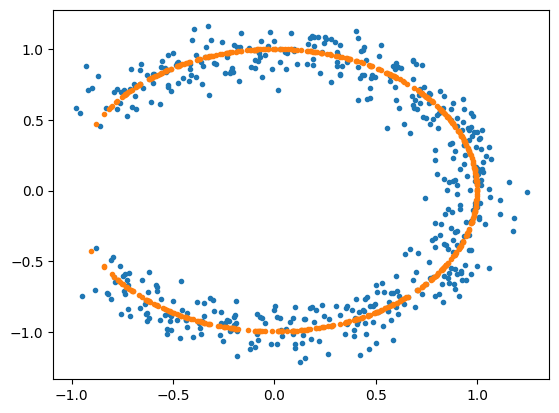

In [30]:
# plot results
plt.plot(noisy_c_data[:,0], noisy_c_data[:,1], '.')
plt.plot(projected_c_mesh.cpu().detach().numpy()[:,0], projected_c_mesh.cpu().detach().numpy()[:,1], '.')
plt.show()